[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EliShayGH/deep-learning-style-transfer/blob/master/cycle-gan/CycleGAN_Exercise.ipynb)

In [1]:
# For google colab only
!git clone https://github.com/EliShayGH/cycle-gan-image2image-translation.git
!cp ./cycle-gan-image2image-translation/helpers.py ./
!cp -r ./cycle-gan-image2image-translation/samples_cyclegan ./
!pip install pillow==6.1.0
!pip3 install scipy==0.17.0

Cloning into 'cycle-gan-image2image-translation'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 30 (delta 5), reused 17 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.
     |████████████████████████████████| 2.1MB 2.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


     |████████████████████████████████| 12.4MB 2.8MB/s 
  ERROR: Failed building wheel for scipy
  Running setup.py clean for scipy
Failed to build scipy
ERROR: yellowbrick 0.9.1 has requirement scipy>=1.0.0, but you'll have scipy 0.17.0 which is incompatible.
ERROR: umap-learn 0.3.9 has requirement scipy>=0.19, but you'll have scipy 0.17.0 which is incompatible.
ERROR: statsmodels 0.10.0 has requirement scipy>=0.18, but you'll have scipy 0.17.0 which is incompatible.
ERROR: pymc3 3.7 has requirement scipy>=0.18.1, but you'll have scipy 0.17.0 which is incompatible.
ERROR: plotnine 0.5.1 has requirement scipy>=1.0.0, but you'll have scipy 0.17.0 which is incompatible.
ERROR: mir-eval 0.5 has requirement scipy>=1.0.0, but you'll have scipy 0.17.0 which is incompatible.
ERROR: magenta 0.3.19 has requirement scipy>=0.18.1, but you'll have scipy 0.17.0 which is incompatible.
ERROR: librosa 0.6.3 has requirement scipy>=1.0.0, but you'll have scipy 0.17.0 which is incompatible.
ERROR: gensim

# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/XY_season_images.png?raw=1' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/horse2zebra.jpg?raw=1' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite/` with a dash or an underscore, so take note, extract the data to your home directory and make sure the below `image_dir` matches. Then you can proceed with the following loading code.

In [2]:
# Download data 

!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
!unzip -q summer2winter-yosemite.zip
!rm summer2winter-yosemite.zip
!mv ./summer2winter_yosemite ./summer2winter-yosemite

--2019-08-01 16:10:56--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.187.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.187.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133783376 (128M) [application/zip]
Saving to: ‘summer2winter-yosemite.zip’

summer2winter-yosem 100%[===================>] 127.58M  16.4MB/s    in 9.1s    

2019-08-01 16:11:06 (14.0 MB/s) - ‘summer2winter-yosemite.zip’ saved [133783376/133783376]



In [0]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [0]:
def get_data_loader(image_type, image_dir='summer2winter-yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [0]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

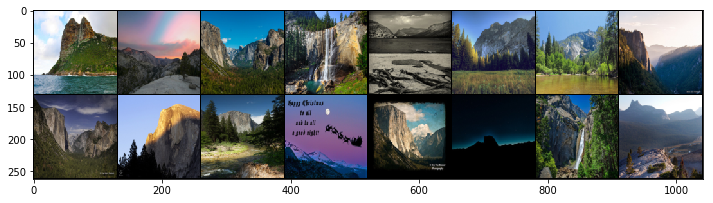

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

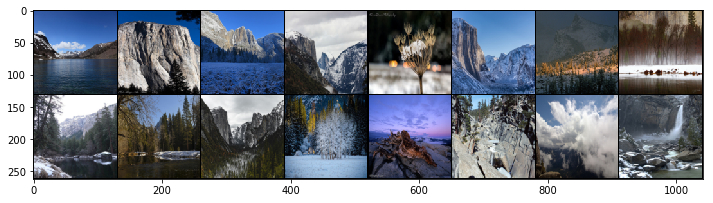

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0275)
Max:  tensor(0.9608)


In [0]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9451)
Scaled max:  tensor(0.9216)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/discriminator_layers.png?raw=1' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        
        # 1st Conv layer has no batch_norm. dim = [64, 64, 64]
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # 2nd Conv layer. dim = [32, 32, 128]
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 3rd Conv layer. dim = [16, 16, 256]
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4th Conv layer. dim = [8, 8, 512]
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 5th Last Conv layer, Classification Layer has no batch_norm and stride is 1. dim = [1, 1, 1]
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # feedforward behavior - relu to all but last layer
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)

        return x

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/cyclegan_generator_ex.png?raw=1' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/resnet_50.png?raw=1' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/resnet_block.png?raw=1' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [0]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.conv1 = conv(conv_dim, conv_dim, 3, 1, batch_norm=True)
        self.conv2 = conv(conv_dim, conv_dim, 3, 1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        output = F.relu(self.conv1(x))
        output = x + self.conv2(output)
        
        return output
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [0]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [0]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        res_layers = []
        for layer in range(n_res_blocks):
          res_layers.append(ResidualBlock(conv_dim*4))

        self.resblocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = self.resblocks.forward(x)

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.tanh(self.deconv3(x))

        return x

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [0]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [15]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [16]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resblocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
  

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/CycleGAN_loss.png?raw=1' width=100% height=25% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/reconstruction_error.png?raw=1' width=100% height=30% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.



In [0]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean((D_out-0)**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss

### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [0]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr=0.0002
beta1=0.5
beta2=0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/cycle_consistency_ex.png?raw=1' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [0]:
# import save code
from helpers import save_samples, checkpoint

In [0]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##
        d_x_optimizer.zero_grad()
        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)

        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_x = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_x)
        D_X_fake_loss = fake_mse_loss(out_x)

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward(retain_graph=True)
        d_x_optimizer.step()
        
        ##   Second: D_Y, real and fake loss components   ##
        d_y_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward(retain_graph=True)
        d_y_optimizer.step()
        

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()
        
        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        reconstructed_Y = G_XtoY(fake_X)

        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)

        ##    Second: generate fake Y images and reconstructed X images    ##
         
        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain X
        out_x = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed y
        reconstructed_X = G_YtoX(fake_Y)

        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)


        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
      
        g_total_loss.backward(retain_graph=True)
        g_optimizer.step()
        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [21]:
n_epochs = 5000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 5000] | d_X_loss: 0.3003 | d_Y_loss: 0.2539 | g_total_loss: 7.9457
Epoch [   20/ 5000] | d_X_loss: 0.3300 | d_Y_loss: 0.5858 | g_total_loss: 6.7557
Epoch [   30/ 5000] | d_X_loss: 0.3275 | d_Y_loss: 0.4958 | g_total_loss: 6.5818
Epoch [   40/ 5000] | d_X_loss: 0.3433 | d_Y_loss: 0.4974 | g_total_loss: 6.3830
Epoch [   50/ 5000] | d_X_loss: 0.5164 | d_Y_loss: 0.3710 | g_total_loss: 5.7628
Epoch [   60/ 5000] | d_X_loss: 0.4195 | d_Y_loss: 0.4861 | g_total_loss: 5.3999
Epoch [   70/ 5000] | d_X_loss: 0.4836 | d_Y_loss: 0.4680 | g_total_loss: 4.7742
Epoch [   80/ 5000] | d_X_loss: 0.5562 | d_Y_loss: 0.4589 | g_total_loss: 5.1759
Epoch [   90/ 5000] | d_X_loss: 0.3842 | d_Y_loss: 0.4361 | g_total_loss: 4.5834


Epoch [  100/ 5000] | d_X_loss: 0.5405 | d_Y_loss: 0.4818 | g_total_loss: 4.4908


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 5000] | d_X_loss: 0.3651 | d_Y_loss: 0.5948 | g_total_loss: 4.6091
Epoch [  120/ 5000] | d_X_loss: 0.4891 | d_Y_loss: 0.4115 | g_total_loss: 4.1858
Epoch [  130/ 5000] | d_X_loss: 0.4363 | d_Y_loss: 0.3148 | g_total_loss: 4.2418
Epoch [  140/ 5000] | d_X_loss: 0.3207 | d_Y_loss: 0.4265 | g_total_loss: 4.9725
Epoch [  150/ 5000] | d_X_loss: 0.4356 | d_Y_loss: 0.3440 | g_total_loss: 4.1385
Epoch [  160/ 5000] | d_X_loss: 0.3334 | d_Y_loss: 0.4616 | g_total_loss: 4.1997
Epoch [  170/ 5000] | d_X_loss: 0.4759 | d_Y_loss: 0.4514 | g_total_loss: 3.9064
Epoch [  180/ 5000] | d_X_loss: 0.4572 | d_Y_loss: 0.3560 | g_total_loss: 4.2880
Epoch [  190/ 5000] | d_X_loss: 0.4264 | d_Y_loss: 0.5120 | g_total_loss: 4.4687


Epoch [  200/ 5000] | d_X_loss: 0.3832 | d_Y_loss: 0.4574 | g_total_loss: 4.2943


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 5000] | d_X_loss: 0.3978 | d_Y_loss: 0.6370 | g_total_loss: 4.7183
Epoch [  220/ 5000] | d_X_loss: 0.4162 | d_Y_loss: 0.3503 | g_total_loss: 4.2031
Epoch [  230/ 5000] | d_X_loss: 0.3521 | d_Y_loss: 0.3957 | g_total_loss: 4.7354
Epoch [  240/ 5000] | d_X_loss: 0.4700 | d_Y_loss: 0.2663 | g_total_loss: 4.3193
Epoch [  250/ 5000] | d_X_loss: 0.4261 | d_Y_loss: 0.4163 | g_total_loss: 4.3978
Epoch [  260/ 5000] | d_X_loss: 0.4437 | d_Y_loss: 0.3453 | g_total_loss: 4.1106
Epoch [  270/ 5000] | d_X_loss: 0.4185 | d_Y_loss: 0.3239 | g_total_loss: 4.0714
Epoch [  280/ 5000] | d_X_loss: 0.4859 | d_Y_loss: 0.4092 | g_total_loss: 3.6829
Epoch [  290/ 5000] | d_X_loss: 0.3226 | d_Y_loss: 0.3500 | g_total_loss: 4.0236


Epoch [  300/ 5000] | d_X_loss: 0.4761 | d_Y_loss: 0.3852 | g_total_loss: 4.8790


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 5000] | d_X_loss: 0.4052 | d_Y_loss: 0.3820 | g_total_loss: 4.0326
Epoch [  320/ 5000] | d_X_loss: 0.4094 | d_Y_loss: 0.4573 | g_total_loss: 3.7237
Epoch [  330/ 5000] | d_X_loss: 0.3391 | d_Y_loss: 0.2990 | g_total_loss: 3.5063
Epoch [  340/ 5000] | d_X_loss: 0.3672 | d_Y_loss: 0.4640 | g_total_loss: 4.5147
Epoch [  350/ 5000] | d_X_loss: 0.4782 | d_Y_loss: 0.4094 | g_total_loss: 3.8177
Epoch [  360/ 5000] | d_X_loss: 0.5151 | d_Y_loss: 0.2936 | g_total_loss: 4.0524
Epoch [  370/ 5000] | d_X_loss: 0.3354 | d_Y_loss: 0.4137 | g_total_loss: 4.1984
Epoch [  380/ 5000] | d_X_loss: 0.4077 | d_Y_loss: 0.3419 | g_total_loss: 4.0918
Epoch [  390/ 5000] | d_X_loss: 0.4578 | d_Y_loss: 0.3598 | g_total_loss: 4.3064


Epoch [  400/ 5000] | d_X_loss: 0.4432 | d_Y_loss: 0.3219 | g_total_loss: 4.3100


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 5000] | d_X_loss: 0.4990 | d_Y_loss: 0.3614 | g_total_loss: 3.9884
Epoch [  420/ 5000] | d_X_loss: 0.4404 | d_Y_loss: 0.3466 | g_total_loss: 3.5883
Epoch [  430/ 5000] | d_X_loss: 0.4214 | d_Y_loss: 0.3093 | g_total_loss: 3.5875
Epoch [  440/ 5000] | d_X_loss: 0.3675 | d_Y_loss: 0.3686 | g_total_loss: 3.8621
Epoch [  450/ 5000] | d_X_loss: 0.4302 | d_Y_loss: 0.3836 | g_total_loss: 3.8563
Epoch [  460/ 5000] | d_X_loss: 0.3173 | d_Y_loss: 0.5014 | g_total_loss: 3.7764
Epoch [  470/ 5000] | d_X_loss: 0.4579 | d_Y_loss: 0.5202 | g_total_loss: 4.4448
Epoch [  480/ 5000] | d_X_loss: 0.4485 | d_Y_loss: 0.3264 | g_total_loss: 4.1870
Epoch [  490/ 5000] | d_X_loss: 0.5556 | d_Y_loss: 0.4567 | g_total_loss: 4.0883


Epoch [  500/ 5000] | d_X_loss: 0.3718 | d_Y_loss: 0.2546 | g_total_loss: 4.1511


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 5000] | d_X_loss: 0.3418 | d_Y_loss: 0.3791 | g_total_loss: 4.1213
Epoch [  520/ 5000] | d_X_loss: 0.4621 | d_Y_loss: 0.4257 | g_total_loss: 3.3160
Epoch [  530/ 5000] | d_X_loss: 0.3007 | d_Y_loss: 0.3852 | g_total_loss: 4.0216
Epoch [  540/ 5000] | d_X_loss: 0.4923 | d_Y_loss: 0.4249 | g_total_loss: 4.5771
Epoch [  550/ 5000] | d_X_loss: 0.4920 | d_Y_loss: 0.3994 | g_total_loss: 4.0719
Epoch [  560/ 5000] | d_X_loss: 0.4700 | d_Y_loss: 0.3482 | g_total_loss: 3.6059
Epoch [  570/ 5000] | d_X_loss: 0.3438 | d_Y_loss: 0.5046 | g_total_loss: 3.7216
Epoch [  580/ 5000] | d_X_loss: 0.4192 | d_Y_loss: 0.7466 | g_total_loss: 5.2960
Epoch [  590/ 5000] | d_X_loss: 0.3342 | d_Y_loss: 0.2693 | g_total_loss: 3.6882


Epoch [  600/ 5000] | d_X_loss: 0.3914 | d_Y_loss: 0.4411 | g_total_loss: 3.7895


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 5000] | d_X_loss: 0.3400 | d_Y_loss: 0.2175 | g_total_loss: 3.7787
Epoch [  620/ 5000] | d_X_loss: 0.3566 | d_Y_loss: 0.2931 | g_total_loss: 4.0844
Epoch [  630/ 5000] | d_X_loss: 0.3143 | d_Y_loss: 0.2378 | g_total_loss: 3.6656
Epoch [  640/ 5000] | d_X_loss: 0.4398 | d_Y_loss: 0.6142 | g_total_loss: 4.6287
Epoch [  650/ 5000] | d_X_loss: 0.4751 | d_Y_loss: 0.4541 | g_total_loss: 3.7727
Epoch [  660/ 5000] | d_X_loss: 0.3091 | d_Y_loss: 0.2330 | g_total_loss: 4.9789
Epoch [  670/ 5000] | d_X_loss: 0.3386 | d_Y_loss: 0.3146 | g_total_loss: 5.9234
Epoch [  680/ 5000] | d_X_loss: 0.3154 | d_Y_loss: 0.4254 | g_total_loss: 4.5469
Epoch [  690/ 5000] | d_X_loss: 0.5365 | d_Y_loss: 0.3081 | g_total_loss: 4.2546


Epoch [  700/ 5000] | d_X_loss: 0.4018 | d_Y_loss: 0.3405 | g_total_loss: 3.5697


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 5000] | d_X_loss: 0.3797 | d_Y_loss: 0.3127 | g_total_loss: 3.9952
Epoch [  720/ 5000] | d_X_loss: 0.4139 | d_Y_loss: 0.3045 | g_total_loss: 4.1314
Epoch [  730/ 5000] | d_X_loss: 0.2098 | d_Y_loss: 0.1985 | g_total_loss: 4.3163
Epoch [  740/ 5000] | d_X_loss: 0.4108 | d_Y_loss: 0.2743 | g_total_loss: 3.4241
Epoch [  750/ 5000] | d_X_loss: 0.6499 | d_Y_loss: 0.3897 | g_total_loss: 2.9375
Epoch [  760/ 5000] | d_X_loss: 0.3907 | d_Y_loss: 0.3689 | g_total_loss: 3.7175
Epoch [  770/ 5000] | d_X_loss: 0.3108 | d_Y_loss: 0.4003 | g_total_loss: 3.6355
Epoch [  780/ 5000] | d_X_loss: 0.3440 | d_Y_loss: 0.3064 | g_total_loss: 4.8546
Epoch [  790/ 5000] | d_X_loss: 0.4299 | d_Y_loss: 0.4361 | g_total_loss: 3.9761


Epoch [  800/ 5000] | d_X_loss: 0.4944 | d_Y_loss: 0.7316 | g_total_loss: 4.7317


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 5000] | d_X_loss: 0.4226 | d_Y_loss: 0.4726 | g_total_loss: 3.1971
Epoch [  820/ 5000] | d_X_loss: 0.3685 | d_Y_loss: 0.3840 | g_total_loss: 3.2666
Epoch [  830/ 5000] | d_X_loss: 0.3953 | d_Y_loss: 0.3409 | g_total_loss: 3.6223
Epoch [  840/ 5000] | d_X_loss: 0.3069 | d_Y_loss: 0.2431 | g_total_loss: 3.8655
Epoch [  850/ 5000] | d_X_loss: 0.3671 | d_Y_loss: 0.4531 | g_total_loss: 3.5457
Epoch [  860/ 5000] | d_X_loss: 0.6474 | d_Y_loss: 0.2833 | g_total_loss: 3.3162
Epoch [  870/ 5000] | d_X_loss: 0.3754 | d_Y_loss: 0.3294 | g_total_loss: 3.9482
Epoch [  880/ 5000] | d_X_loss: 0.1607 | d_Y_loss: 0.2513 | g_total_loss: 4.4366
Epoch [  890/ 5000] | d_X_loss: 0.3443 | d_Y_loss: 0.2721 | g_total_loss: 3.7733


Epoch [  900/ 5000] | d_X_loss: 0.6806 | d_Y_loss: 0.4668 | g_total_loss: 3.0883


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 5000] | d_X_loss: 0.3445 | d_Y_loss: 0.4428 | g_total_loss: 4.0719
Epoch [  920/ 5000] | d_X_loss: 0.3712 | d_Y_loss: 0.3809 | g_total_loss: 3.7076
Epoch [  930/ 5000] | d_X_loss: 0.3052 | d_Y_loss: 0.3816 | g_total_loss: 3.3277
Epoch [  940/ 5000] | d_X_loss: 0.3503 | d_Y_loss: 0.2103 | g_total_loss: 3.7336
Epoch [  950/ 5000] | d_X_loss: 0.3674 | d_Y_loss: 0.4949 | g_total_loss: 3.9782
Epoch [  960/ 5000] | d_X_loss: 0.3920 | d_Y_loss: 0.2749 | g_total_loss: 4.1882
Epoch [  970/ 5000] | d_X_loss: 0.3643 | d_Y_loss: 0.4073 | g_total_loss: 3.7152
Epoch [  980/ 5000] | d_X_loss: 0.4778 | d_Y_loss: 0.8076 | g_total_loss: 3.4751
Epoch [  990/ 5000] | d_X_loss: 0.3670 | d_Y_loss: 0.4476 | g_total_loss: 3.7401


Epoch [ 1000/ 5000] | d_X_loss: 0.4937 | d_Y_loss: 0.3072 | g_total_loss: 3.6276


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 5000] | d_X_loss: 0.2757 | d_Y_loss: 0.2891 | g_total_loss: 4.1812
Epoch [ 1020/ 5000] | d_X_loss: 0.4234 | d_Y_loss: 0.2077 | g_total_loss: 3.7997
Epoch [ 1030/ 5000] | d_X_loss: 0.4427 | d_Y_loss: 0.3567 | g_total_loss: 3.7526
Epoch [ 1040/ 5000] | d_X_loss: 0.4657 | d_Y_loss: 0.3252 | g_total_loss: 4.3464
Epoch [ 1050/ 5000] | d_X_loss: 0.3942 | d_Y_loss: 0.2991 | g_total_loss: 4.3086
Epoch [ 1060/ 5000] | d_X_loss: 0.4399 | d_Y_loss: 0.3081 | g_total_loss: 3.3342
Epoch [ 1070/ 5000] | d_X_loss: 0.4126 | d_Y_loss: 0.2958 | g_total_loss: 3.7656
Epoch [ 1080/ 5000] | d_X_loss: 0.4040 | d_Y_loss: 0.3232 | g_total_loss: 4.2741
Epoch [ 1090/ 5000] | d_X_loss: 0.3136 | d_Y_loss: 0.3503 | g_total_loss: 3.5565


Epoch [ 1100/ 5000] | d_X_loss: 0.4038 | d_Y_loss: 0.7893 | g_total_loss: 3.8550


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 5000] | d_X_loss: 0.3046 | d_Y_loss: 0.3201 | g_total_loss: 4.0425
Epoch [ 1120/ 5000] | d_X_loss: 0.3467 | d_Y_loss: 0.2174 | g_total_loss: 3.5481
Epoch [ 1130/ 5000] | d_X_loss: 0.2645 | d_Y_loss: 0.4116 | g_total_loss: 4.3463
Epoch [ 1140/ 5000] | d_X_loss: 0.4111 | d_Y_loss: 0.2704 | g_total_loss: 3.3857
Epoch [ 1150/ 5000] | d_X_loss: 0.4172 | d_Y_loss: 0.4691 | g_total_loss: 3.4475
Epoch [ 1160/ 5000] | d_X_loss: 0.4158 | d_Y_loss: 0.2554 | g_total_loss: 4.3923
Epoch [ 1170/ 5000] | d_X_loss: 0.2680 | d_Y_loss: 0.2903 | g_total_loss: 3.8882
Epoch [ 1180/ 5000] | d_X_loss: 0.3052 | d_Y_loss: 0.2657 | g_total_loss: 3.5265
Epoch [ 1190/ 5000] | d_X_loss: 0.3606 | d_Y_loss: 0.2443 | g_total_loss: 4.1479


Epoch [ 1200/ 5000] | d_X_loss: 0.3534 | d_Y_loss: 0.3371 | g_total_loss: 4.5114


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 5000] | d_X_loss: 0.3862 | d_Y_loss: 0.5250 | g_total_loss: 4.8514
Epoch [ 1220/ 5000] | d_X_loss: 0.3000 | d_Y_loss: 0.4626 | g_total_loss: 3.3909
Epoch [ 1230/ 5000] | d_X_loss: 0.3624 | d_Y_loss: 0.3660 | g_total_loss: 4.4060
Epoch [ 1240/ 5000] | d_X_loss: 0.4704 | d_Y_loss: 0.2819 | g_total_loss: 5.2988
Epoch [ 1250/ 5000] | d_X_loss: 0.4405 | d_Y_loss: 0.3453 | g_total_loss: 3.7257
Epoch [ 1260/ 5000] | d_X_loss: 0.2530 | d_Y_loss: 0.2112 | g_total_loss: 3.5988
Epoch [ 1270/ 5000] | d_X_loss: 0.3218 | d_Y_loss: 0.4167 | g_total_loss: 3.8260
Epoch [ 1280/ 5000] | d_X_loss: 0.2514 | d_Y_loss: 0.3701 | g_total_loss: 4.1608
Epoch [ 1290/ 5000] | d_X_loss: 0.2645 | d_Y_loss: 0.3834 | g_total_loss: 3.2271


Epoch [ 1300/ 5000] | d_X_loss: 0.4245 | d_Y_loss: 0.2432 | g_total_loss: 3.6795


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 5000] | d_X_loss: 0.2934 | d_Y_loss: 0.2054 | g_total_loss: 3.6235
Epoch [ 1320/ 5000] | d_X_loss: 0.2461 | d_Y_loss: 0.3225 | g_total_loss: 3.5399
Epoch [ 1330/ 5000] | d_X_loss: 0.2881 | d_Y_loss: 0.2620 | g_total_loss: 4.4319
Epoch [ 1340/ 5000] | d_X_loss: 0.3129 | d_Y_loss: 0.1238 | g_total_loss: 3.9528
Epoch [ 1350/ 5000] | d_X_loss: 0.2934 | d_Y_loss: 0.2181 | g_total_loss: 4.0878
Epoch [ 1360/ 5000] | d_X_loss: 0.4315 | d_Y_loss: 0.3036 | g_total_loss: 3.7550
Epoch [ 1370/ 5000] | d_X_loss: 0.2948 | d_Y_loss: 0.1985 | g_total_loss: 4.2262
Epoch [ 1380/ 5000] | d_X_loss: 0.3428 | d_Y_loss: 0.5150 | g_total_loss: 4.3326
Epoch [ 1390/ 5000] | d_X_loss: 0.4025 | d_Y_loss: 0.2373 | g_total_loss: 3.3643


Epoch [ 1400/ 5000] | d_X_loss: 0.3502 | d_Y_loss: 0.2709 | g_total_loss: 4.1014


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 5000] | d_X_loss: 0.3196 | d_Y_loss: 0.5419 | g_total_loss: 3.3945
Epoch [ 1420/ 5000] | d_X_loss: 0.4270 | d_Y_loss: 0.6506 | g_total_loss: 3.3114
Epoch [ 1430/ 5000] | d_X_loss: 0.3777 | d_Y_loss: 0.2696 | g_total_loss: 3.5639
Epoch [ 1440/ 5000] | d_X_loss: 0.3766 | d_Y_loss: 0.2956 | g_total_loss: 3.3627
Epoch [ 1450/ 5000] | d_X_loss: 0.2815 | d_Y_loss: 0.3879 | g_total_loss: 3.2787
Epoch [ 1460/ 5000] | d_X_loss: 0.2567 | d_Y_loss: 0.2448 | g_total_loss: 3.2801
Epoch [ 1470/ 5000] | d_X_loss: 0.2663 | d_Y_loss: 0.6781 | g_total_loss: 4.3307
Epoch [ 1480/ 5000] | d_X_loss: 0.3696 | d_Y_loss: 0.4542 | g_total_loss: 2.8025
Epoch [ 1490/ 5000] | d_X_loss: 0.3178 | d_Y_loss: 0.2551 | g_total_loss: 3.6498


Epoch [ 1500/ 5000] | d_X_loss: 0.3105 | d_Y_loss: 0.1711 | g_total_loss: 3.5628


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 5000] | d_X_loss: 0.3533 | d_Y_loss: 0.2292 | g_total_loss: 3.6496
Epoch [ 1520/ 5000] | d_X_loss: 0.5644 | d_Y_loss: 0.2829 | g_total_loss: 4.4965
Epoch [ 1530/ 5000] | d_X_loss: 0.2573 | d_Y_loss: 0.3979 | g_total_loss: 3.4443
Epoch [ 1540/ 5000] | d_X_loss: 0.2581 | d_Y_loss: 0.1917 | g_total_loss: 4.3641
Epoch [ 1550/ 5000] | d_X_loss: 0.2499 | d_Y_loss: 0.3270 | g_total_loss: 3.4338
Epoch [ 1560/ 5000] | d_X_loss: 0.2543 | d_Y_loss: 0.3392 | g_total_loss: 3.4958
Epoch [ 1570/ 5000] | d_X_loss: 0.3129 | d_Y_loss: 0.5816 | g_total_loss: 3.8963
Epoch [ 1580/ 5000] | d_X_loss: 0.2962 | d_Y_loss: 0.6817 | g_total_loss: 4.1094
Epoch [ 1590/ 5000] | d_X_loss: 0.1777 | d_Y_loss: 0.2179 | g_total_loss: 3.9364


Epoch [ 1600/ 5000] | d_X_loss: 0.5214 | d_Y_loss: 0.2570 | g_total_loss: 3.2729


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 5000] | d_X_loss: 0.2545 | d_Y_loss: 0.2645 | g_total_loss: 4.3534
Epoch [ 1620/ 5000] | d_X_loss: 0.2136 | d_Y_loss: 0.2156 | g_total_loss: 4.0592
Epoch [ 1630/ 5000] | d_X_loss: 0.2406 | d_Y_loss: 0.3205 | g_total_loss: 3.9446
Epoch [ 1640/ 5000] | d_X_loss: 0.1177 | d_Y_loss: 0.2313 | g_total_loss: 4.0277
Epoch [ 1650/ 5000] | d_X_loss: 0.2082 | d_Y_loss: 0.6650 | g_total_loss: 3.0919
Epoch [ 1660/ 5000] | d_X_loss: 0.3440 | d_Y_loss: 0.2001 | g_total_loss: 5.2956
Epoch [ 1670/ 5000] | d_X_loss: 0.3516 | d_Y_loss: 0.2569 | g_total_loss: 3.7870
Epoch [ 1680/ 5000] | d_X_loss: 0.2386 | d_Y_loss: 0.0955 | g_total_loss: 3.6487
Epoch [ 1690/ 5000] | d_X_loss: 0.1756 | d_Y_loss: 0.3404 | g_total_loss: 3.4491


Epoch [ 1700/ 5000] | d_X_loss: 0.1658 | d_Y_loss: 0.2721 | g_total_loss: 4.4740


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 5000] | d_X_loss: 0.2116 | d_Y_loss: 0.3031 | g_total_loss: 4.4588
Epoch [ 1720/ 5000] | d_X_loss: 0.2174 | d_Y_loss: 0.2291 | g_total_loss: 3.4150
Epoch [ 1730/ 5000] | d_X_loss: 0.1247 | d_Y_loss: 0.1883 | g_total_loss: 3.6744
Epoch [ 1740/ 5000] | d_X_loss: 0.2725 | d_Y_loss: 0.1349 | g_total_loss: 3.6868
Epoch [ 1750/ 5000] | d_X_loss: 0.1282 | d_Y_loss: 0.2337 | g_total_loss: 4.4641
Epoch [ 1760/ 5000] | d_X_loss: 0.3005 | d_Y_loss: 0.2128 | g_total_loss: 3.3842
Epoch [ 1770/ 5000] | d_X_loss: 0.2044 | d_Y_loss: 0.3657 | g_total_loss: 3.3985
Epoch [ 1780/ 5000] | d_X_loss: 0.2629 | d_Y_loss: 0.3451 | g_total_loss: 4.3825
Epoch [ 1790/ 5000] | d_X_loss: 0.2105 | d_Y_loss: 0.2754 | g_total_loss: 3.8572


Epoch [ 1800/ 5000] | d_X_loss: 0.2688 | d_Y_loss: 0.2523 | g_total_loss: 4.5545


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 5000] | d_X_loss: 0.3791 | d_Y_loss: 0.2471 | g_total_loss: 3.6806
Epoch [ 1820/ 5000] | d_X_loss: 0.9440 | d_Y_loss: 0.2083 | g_total_loss: 2.7767
Epoch [ 1830/ 5000] | d_X_loss: 0.2391 | d_Y_loss: 0.4688 | g_total_loss: 4.3402
Epoch [ 1840/ 5000] | d_X_loss: 0.2195 | d_Y_loss: 0.1402 | g_total_loss: 3.8056
Epoch [ 1850/ 5000] | d_X_loss: 0.1921 | d_Y_loss: 0.2525 | g_total_loss: 4.2411
Epoch [ 1860/ 5000] | d_X_loss: 0.1479 | d_Y_loss: 0.2849 | g_total_loss: 3.5640
Epoch [ 1870/ 5000] | d_X_loss: 0.3374 | d_Y_loss: 0.3164 | g_total_loss: 4.1750
Epoch [ 1880/ 5000] | d_X_loss: 0.2387 | d_Y_loss: 0.2934 | g_total_loss: 4.0552
Epoch [ 1890/ 5000] | d_X_loss: 0.2949 | d_Y_loss: 0.1363 | g_total_loss: 4.0637


Epoch [ 1900/ 5000] | d_X_loss: 0.3760 | d_Y_loss: 0.2552 | g_total_loss: 3.3663


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 5000] | d_X_loss: 0.1607 | d_Y_loss: 0.2180 | g_total_loss: 3.1469
Epoch [ 1920/ 5000] | d_X_loss: 0.2772 | d_Y_loss: 0.3139 | g_total_loss: 3.2508
Epoch [ 1930/ 5000] | d_X_loss: 0.2587 | d_Y_loss: 0.5755 | g_total_loss: 3.2715
Epoch [ 1940/ 5000] | d_X_loss: 0.6772 | d_Y_loss: 0.2739 | g_total_loss: 3.1940
Epoch [ 1950/ 5000] | d_X_loss: 0.3333 | d_Y_loss: 0.2451 | g_total_loss: 3.7422
Epoch [ 1960/ 5000] | d_X_loss: 0.0946 | d_Y_loss: 0.3696 | g_total_loss: 3.6386
Epoch [ 1970/ 5000] | d_X_loss: 0.2786 | d_Y_loss: 0.1373 | g_total_loss: 4.5696
Epoch [ 1980/ 5000] | d_X_loss: 0.1043 | d_Y_loss: 0.1938 | g_total_loss: 3.6127
Epoch [ 1990/ 5000] | d_X_loss: 0.3438 | d_Y_loss: 0.3026 | g_total_loss: 3.9914


Epoch [ 2000/ 5000] | d_X_loss: 0.1539 | d_Y_loss: 0.2439 | g_total_loss: 3.2341


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/ 5000] | d_X_loss: 0.3185 | d_Y_loss: 0.2688 | g_total_loss: 4.4565
Epoch [ 2020/ 5000] | d_X_loss: 0.3549 | d_Y_loss: 0.2019 | g_total_loss: 4.3537
Epoch [ 2030/ 5000] | d_X_loss: 0.2930 | d_Y_loss: 0.1694 | g_total_loss: 3.3278
Epoch [ 2040/ 5000] | d_X_loss: 0.1832 | d_Y_loss: 0.1505 | g_total_loss: 3.2131
Epoch [ 2050/ 5000] | d_X_loss: 0.2530 | d_Y_loss: 0.1162 | g_total_loss: 4.4618
Epoch [ 2060/ 5000] | d_X_loss: 0.1615 | d_Y_loss: 1.0648 | g_total_loss: 4.7317
Epoch [ 2070/ 5000] | d_X_loss: 0.1825 | d_Y_loss: 0.3228 | g_total_loss: 3.8256
Epoch [ 2080/ 5000] | d_X_loss: 0.3124 | d_Y_loss: 0.2141 | g_total_loss: 5.1196
Epoch [ 2090/ 5000] | d_X_loss: 0.2560 | d_Y_loss: 0.2359 | g_total_loss: 3.6363


Epoch [ 2100/ 5000] | d_X_loss: 0.2504 | d_Y_loss: 0.2854 | g_total_loss: 3.6745


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 5000] | d_X_loss: 0.2181 | d_Y_loss: 0.2489 | g_total_loss: 4.3672
Epoch [ 2120/ 5000] | d_X_loss: 0.2113 | d_Y_loss: 0.3347 | g_total_loss: 3.3009
Epoch [ 2130/ 5000] | d_X_loss: 0.2112 | d_Y_loss: 0.1725 | g_total_loss: 3.7916
Epoch [ 2140/ 5000] | d_X_loss: 0.2287 | d_Y_loss: 0.1984 | g_total_loss: 3.8264
Epoch [ 2150/ 5000] | d_X_loss: 0.1892 | d_Y_loss: 0.1239 | g_total_loss: 3.7975
Epoch [ 2160/ 5000] | d_X_loss: 0.2309 | d_Y_loss: 0.3615 | g_total_loss: 3.5074
Epoch [ 2170/ 5000] | d_X_loss: 0.2122 | d_Y_loss: 0.2425 | g_total_loss: 3.7648
Epoch [ 2180/ 5000] | d_X_loss: 0.1340 | d_Y_loss: 0.2602 | g_total_loss: 3.8718
Epoch [ 2190/ 5000] | d_X_loss: 0.1694 | d_Y_loss: 0.4312 | g_total_loss: 3.0854


Epoch [ 2200/ 5000] | d_X_loss: 0.2280 | d_Y_loss: 0.1772 | g_total_loss: 4.5609


Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 5000] | d_X_loss: 0.2240 | d_Y_loss: 0.0856 | g_total_loss: 4.4716
Epoch [ 2220/ 5000] | d_X_loss: 0.3222 | d_Y_loss: 0.1861 | g_total_loss: 4.4191
Epoch [ 2230/ 5000] | d_X_loss: 0.1134 | d_Y_loss: 0.1032 | g_total_loss: 3.8547
Epoch [ 2240/ 5000] | d_X_loss: 0.4829 | d_Y_loss: 0.1997 | g_total_loss: 4.7799
Epoch [ 2250/ 5000] | d_X_loss: 0.2233 | d_Y_loss: 0.1039 | g_total_loss: 4.1329
Epoch [ 2260/ 5000] | d_X_loss: 0.2359 | d_Y_loss: 0.4586 | g_total_loss: 3.5104
Epoch [ 2270/ 5000] | d_X_loss: 0.3497 | d_Y_loss: 0.2108 | g_total_loss: 4.1583
Epoch [ 2280/ 5000] | d_X_loss: 0.6285 | d_Y_loss: 0.3529 | g_total_loss: 2.8440
Epoch [ 2290/ 5000] | d_X_loss: 0.1590 | d_Y_loss: 0.0927 | g_total_loss: 4.0656


Epoch [ 2300/ 5000] | d_X_loss: 0.1961 | d_Y_loss: 0.2417 | g_total_loss: 4.1280


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 5000] | d_X_loss: 0.4211 | d_Y_loss: 0.0682 | g_total_loss: 4.2029
Epoch [ 2320/ 5000] | d_X_loss: 0.3381 | d_Y_loss: 0.1040 | g_total_loss: 3.8792
Epoch [ 2330/ 5000] | d_X_loss: 0.2485 | d_Y_loss: 0.0492 | g_total_loss: 4.8896
Epoch [ 2340/ 5000] | d_X_loss: 0.2690 | d_Y_loss: 0.4648 | g_total_loss: 3.0105
Epoch [ 2350/ 5000] | d_X_loss: 0.2153 | d_Y_loss: 0.2497 | g_total_loss: 4.1742
Epoch [ 2360/ 5000] | d_X_loss: 0.3716 | d_Y_loss: 0.1416 | g_total_loss: 3.7604
Epoch [ 2370/ 5000] | d_X_loss: 0.2481 | d_Y_loss: 0.1624 | g_total_loss: 3.4944
Epoch [ 2380/ 5000] | d_X_loss: 0.2879 | d_Y_loss: 0.2188 | g_total_loss: 3.9293
Epoch [ 2390/ 5000] | d_X_loss: 0.2040 | d_Y_loss: 0.2940 | g_total_loss: 3.8367


Epoch [ 2400/ 5000] | d_X_loss: 0.2858 | d_Y_loss: 0.2675 | g_total_loss: 4.2714


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 5000] | d_X_loss: 0.2616 | d_Y_loss: 0.2437 | g_total_loss: 3.2432
Epoch [ 2420/ 5000] | d_X_loss: 0.1819 | d_Y_loss: 0.1888 | g_total_loss: 4.1104
Epoch [ 2430/ 5000] | d_X_loss: 0.1257 | d_Y_loss: 0.1887 | g_total_loss: 3.2859
Epoch [ 2440/ 5000] | d_X_loss: 0.1477 | d_Y_loss: 0.1747 | g_total_loss: 3.3030
Epoch [ 2450/ 5000] | d_X_loss: 0.5319 | d_Y_loss: 0.2119 | g_total_loss: 5.7281
Epoch [ 2460/ 5000] | d_X_loss: 0.1655 | d_Y_loss: 0.2095 | g_total_loss: 3.6373
Epoch [ 2470/ 5000] | d_X_loss: 0.1709 | d_Y_loss: 0.1031 | g_total_loss: 3.8686
Epoch [ 2480/ 5000] | d_X_loss: 0.2302 | d_Y_loss: 0.2170 | g_total_loss: 4.0272
Epoch [ 2490/ 5000] | d_X_loss: 0.1710 | d_Y_loss: 0.1947 | g_total_loss: 3.2536


Epoch [ 2500/ 5000] | d_X_loss: 0.1644 | d_Y_loss: 0.2003 | g_total_loss: 4.9064


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 5000] | d_X_loss: 0.2531 | d_Y_loss: 0.1587 | g_total_loss: 3.8874
Epoch [ 2520/ 5000] | d_X_loss: 0.1589 | d_Y_loss: 0.2091 | g_total_loss: 3.5119
Epoch [ 2530/ 5000] | d_X_loss: 0.2440 | d_Y_loss: 0.1169 | g_total_loss: 4.2613
Epoch [ 2540/ 5000] | d_X_loss: 0.1103 | d_Y_loss: 0.2215 | g_total_loss: 4.6763
Epoch [ 2550/ 5000] | d_X_loss: 0.1290 | d_Y_loss: 0.1353 | g_total_loss: 3.9286
Epoch [ 2560/ 5000] | d_X_loss: 0.3070 | d_Y_loss: 0.1559 | g_total_loss: 4.0633
Epoch [ 2570/ 5000] | d_X_loss: 0.4031 | d_Y_loss: 0.0839 | g_total_loss: 4.0546
Epoch [ 2580/ 5000] | d_X_loss: 0.2364 | d_Y_loss: 0.1238 | g_total_loss: 3.6096
Epoch [ 2590/ 5000] | d_X_loss: 0.1348 | d_Y_loss: 0.1831 | g_total_loss: 3.6943


Epoch [ 2600/ 5000] | d_X_loss: 0.1802 | d_Y_loss: 0.1688 | g_total_loss: 3.3148


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 5000] | d_X_loss: 0.7789 | d_Y_loss: 0.2457 | g_total_loss: 3.8450
Epoch [ 2620/ 5000] | d_X_loss: 0.1573 | d_Y_loss: 0.2230 | g_total_loss: 3.5250
Epoch [ 2630/ 5000] | d_X_loss: 0.2016 | d_Y_loss: 0.3687 | g_total_loss: 3.3103
Epoch [ 2640/ 5000] | d_X_loss: 0.1229 | d_Y_loss: 0.1865 | g_total_loss: 3.7154
Epoch [ 2650/ 5000] | d_X_loss: 0.1195 | d_Y_loss: 0.1541 | g_total_loss: 3.3592
Epoch [ 2660/ 5000] | d_X_loss: 0.2210 | d_Y_loss: 0.1101 | g_total_loss: 3.7299
Epoch [ 2670/ 5000] | d_X_loss: 0.1292 | d_Y_loss: 0.0857 | g_total_loss: 3.8093
Epoch [ 2680/ 5000] | d_X_loss: 0.1644 | d_Y_loss: 0.0525 | g_total_loss: 4.0721
Epoch [ 2690/ 5000] | d_X_loss: 0.2490 | d_Y_loss: 0.1818 | g_total_loss: 4.1084


Epoch [ 2700/ 5000] | d_X_loss: 0.1040 | d_Y_loss: 0.2258 | g_total_loss: 4.5642


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 5000] | d_X_loss: 0.1359 | d_Y_loss: 0.0814 | g_total_loss: 4.6539
Epoch [ 2720/ 5000] | d_X_loss: 0.2099 | d_Y_loss: 0.1629 | g_total_loss: 4.6608
Epoch [ 2730/ 5000] | d_X_loss: 0.3686 | d_Y_loss: 0.1476 | g_total_loss: 4.7291
Epoch [ 2740/ 5000] | d_X_loss: 0.1722 | d_Y_loss: 0.0811 | g_total_loss: 3.7292
Epoch [ 2750/ 5000] | d_X_loss: 0.1949 | d_Y_loss: 0.2303 | g_total_loss: 3.2254
Epoch [ 2760/ 5000] | d_X_loss: 0.2370 | d_Y_loss: 0.1220 | g_total_loss: 3.7259
Epoch [ 2770/ 5000] | d_X_loss: 0.1453 | d_Y_loss: 0.1237 | g_total_loss: 4.3756
Epoch [ 2780/ 5000] | d_X_loss: 0.1837 | d_Y_loss: 0.0577 | g_total_loss: 4.1432
Epoch [ 2790/ 5000] | d_X_loss: 0.0986 | d_Y_loss: 0.0788 | g_total_loss: 4.2220


Epoch [ 2800/ 5000] | d_X_loss: 0.1415 | d_Y_loss: 0.1994 | g_total_loss: 4.0500


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 5000] | d_X_loss: 0.1730 | d_Y_loss: 0.5198 | g_total_loss: 3.1262
Epoch [ 2820/ 5000] | d_X_loss: 0.1040 | d_Y_loss: 0.2249 | g_total_loss: 4.1367
Epoch [ 2830/ 5000] | d_X_loss: 0.1638 | d_Y_loss: 0.2097 | g_total_loss: 4.1909
Epoch [ 2840/ 5000] | d_X_loss: 0.2072 | d_Y_loss: 0.1683 | g_total_loss: 3.5430
Epoch [ 2850/ 5000] | d_X_loss: 0.1452 | d_Y_loss: 0.1615 | g_total_loss: 3.5189
Epoch [ 2860/ 5000] | d_X_loss: 0.1278 | d_Y_loss: 0.1427 | g_total_loss: 3.4803
Epoch [ 2870/ 5000] | d_X_loss: 0.1951 | d_Y_loss: 0.1309 | g_total_loss: 3.9709
Epoch [ 2880/ 5000] | d_X_loss: 0.1479 | d_Y_loss: 0.0536 | g_total_loss: 4.1320
Epoch [ 2890/ 5000] | d_X_loss: 0.2923 | d_Y_loss: 0.0854 | g_total_loss: 4.2500


Epoch [ 2900/ 5000] | d_X_loss: 0.1097 | d_Y_loss: 0.1104 | g_total_loss: 3.8063


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 5000] | d_X_loss: 0.2442 | d_Y_loss: 0.6529 | g_total_loss: 3.2707
Epoch [ 2920/ 5000] | d_X_loss: 0.1615 | d_Y_loss: 0.2161 | g_total_loss: 3.9803
Epoch [ 2930/ 5000] | d_X_loss: 0.2353 | d_Y_loss: 0.1739 | g_total_loss: 4.1450
Epoch [ 2940/ 5000] | d_X_loss: 0.1693 | d_Y_loss: 0.1238 | g_total_loss: 3.4882
Epoch [ 2950/ 5000] | d_X_loss: 0.2658 | d_Y_loss: 0.5457 | g_total_loss: 3.3368
Epoch [ 2960/ 5000] | d_X_loss: 0.2267 | d_Y_loss: 0.1766 | g_total_loss: 4.0928
Epoch [ 2970/ 5000] | d_X_loss: 0.1393 | d_Y_loss: 0.2025 | g_total_loss: 3.9942
Epoch [ 2980/ 5000] | d_X_loss: 0.1398 | d_Y_loss: 0.1373 | g_total_loss: 4.0994
Epoch [ 2990/ 5000] | d_X_loss: 0.4364 | d_Y_loss: 0.2275 | g_total_loss: 3.0645


Epoch [ 3000/ 5000] | d_X_loss: 0.1705 | d_Y_loss: 0.1233 | g_total_loss: 4.1697


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/ 5000] | d_X_loss: 0.1208 | d_Y_loss: 0.1133 | g_total_loss: 3.5318
Epoch [ 3020/ 5000] | d_X_loss: 0.1368 | d_Y_loss: 0.1277 | g_total_loss: 3.7252
Epoch [ 3030/ 5000] | d_X_loss: 0.3573 | d_Y_loss: 0.1508 | g_total_loss: 3.7338
Epoch [ 3040/ 5000] | d_X_loss: 0.2156 | d_Y_loss: 0.0449 | g_total_loss: 4.4670
Epoch [ 3050/ 5000] | d_X_loss: 0.1112 | d_Y_loss: 0.1636 | g_total_loss: 3.8278
Epoch [ 3060/ 5000] | d_X_loss: 0.3039 | d_Y_loss: 0.1920 | g_total_loss: 4.3062
Epoch [ 3070/ 5000] | d_X_loss: 0.1765 | d_Y_loss: 0.2165 | g_total_loss: 3.7497
Epoch [ 3080/ 5000] | d_X_loss: 0.0883 | d_Y_loss: 0.1783 | g_total_loss: 4.6132
Epoch [ 3090/ 5000] | d_X_loss: 0.2940 | d_Y_loss: 0.3496 | g_total_loss: 3.5454


Epoch [ 3100/ 5000] | d_X_loss: 0.2514 | d_Y_loss: 0.1820 | g_total_loss: 3.6455


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 5000] | d_X_loss: 0.1695 | d_Y_loss: 0.0864 | g_total_loss: 7.1944
Epoch [ 3120/ 5000] | d_X_loss: 0.2704 | d_Y_loss: 0.1391 | g_total_loss: 4.3861
Epoch [ 3130/ 5000] | d_X_loss: 0.4915 | d_Y_loss: 0.1918 | g_total_loss: 3.1338
Epoch [ 3140/ 5000] | d_X_loss: 0.2382 | d_Y_loss: 0.1877 | g_total_loss: 3.9958
Epoch [ 3150/ 5000] | d_X_loss: 0.1676 | d_Y_loss: 0.0903 | g_total_loss: 4.4158
Epoch [ 3160/ 5000] | d_X_loss: 0.2353 | d_Y_loss: 0.1349 | g_total_loss: 4.9516
Epoch [ 3170/ 5000] | d_X_loss: 0.1384 | d_Y_loss: 0.1492 | g_total_loss: 3.7806
Epoch [ 3180/ 5000] | d_X_loss: 0.1905 | d_Y_loss: 0.0834 | g_total_loss: 4.0168
Epoch [ 3190/ 5000] | d_X_loss: 0.0870 | d_Y_loss: 0.0928 | g_total_loss: 4.1242


Epoch [ 3200/ 5000] | d_X_loss: 0.2471 | d_Y_loss: 0.1094 | g_total_loss: 3.9093


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 5000] | d_X_loss: 0.1221 | d_Y_loss: 0.2493 | g_total_loss: 3.3827
Epoch [ 3220/ 5000] | d_X_loss: 0.1084 | d_Y_loss: 0.0872 | g_total_loss: 4.4720
Epoch [ 3230/ 5000] | d_X_loss: 0.1410 | d_Y_loss: 0.1828 | g_total_loss: 4.4760
Epoch [ 3240/ 5000] | d_X_loss: 0.1296 | d_Y_loss: 0.0925 | g_total_loss: 4.5843
Epoch [ 3250/ 5000] | d_X_loss: 0.2115 | d_Y_loss: 0.1729 | g_total_loss: 3.6204
Epoch [ 3260/ 5000] | d_X_loss: 0.2389 | d_Y_loss: 0.0744 | g_total_loss: 3.2469
Epoch [ 3270/ 5000] | d_X_loss: 0.1112 | d_Y_loss: 0.0989 | g_total_loss: 3.5221
Epoch [ 3280/ 5000] | d_X_loss: 0.0485 | d_Y_loss: 0.1014 | g_total_loss: 4.2968
Epoch [ 3290/ 5000] | d_X_loss: 0.1571 | d_Y_loss: 0.5450 | g_total_loss: 2.8379


Epoch [ 3300/ 5000] | d_X_loss: 0.2134 | d_Y_loss: 0.1592 | g_total_loss: 3.6222


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 5000] | d_X_loss: 0.0848 | d_Y_loss: 0.0877 | g_total_loss: 4.2593
Epoch [ 3320/ 5000] | d_X_loss: 0.2124 | d_Y_loss: 0.0974 | g_total_loss: 3.3858
Epoch [ 3330/ 5000] | d_X_loss: 0.0743 | d_Y_loss: 0.1684 | g_total_loss: 3.8030
Epoch [ 3340/ 5000] | d_X_loss: 0.1351 | d_Y_loss: 0.2885 | g_total_loss: 3.7240
Epoch [ 3350/ 5000] | d_X_loss: 0.2373 | d_Y_loss: 0.1087 | g_total_loss: 3.9599
Epoch [ 3360/ 5000] | d_X_loss: 0.2027 | d_Y_loss: 0.1152 | g_total_loss: 4.0194
Epoch [ 3370/ 5000] | d_X_loss: 0.1486 | d_Y_loss: 0.2298 | g_total_loss: 4.4295
Epoch [ 3380/ 5000] | d_X_loss: 0.1564 | d_Y_loss: 0.1885 | g_total_loss: 3.5470
Epoch [ 3390/ 5000] | d_X_loss: 0.2063 | d_Y_loss: 0.1501 | g_total_loss: 3.9184


Epoch [ 3400/ 5000] | d_X_loss: 0.1153 | d_Y_loss: 0.1315 | g_total_loss: 4.1620


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 5000] | d_X_loss: 0.1247 | d_Y_loss: 0.1998 | g_total_loss: 3.3882
Epoch [ 3420/ 5000] | d_X_loss: 0.3166 | d_Y_loss: 0.1947 | g_total_loss: 3.3606
Epoch [ 3430/ 5000] | d_X_loss: 0.4626 | d_Y_loss: 0.2712 | g_total_loss: 2.9123
Epoch [ 3440/ 5000] | d_X_loss: 0.0948 | d_Y_loss: 0.1202 | g_total_loss: 4.2076
Epoch [ 3450/ 5000] | d_X_loss: 0.1097 | d_Y_loss: 0.1141 | g_total_loss: 3.4116
Epoch [ 3460/ 5000] | d_X_loss: 0.0421 | d_Y_loss: 0.1277 | g_total_loss: 3.9305
Epoch [ 3470/ 5000] | d_X_loss: 0.1835 | d_Y_loss: 0.2424 | g_total_loss: 4.5536
Epoch [ 3480/ 5000] | d_X_loss: 0.1146 | d_Y_loss: 0.1699 | g_total_loss: 3.5128
Epoch [ 3490/ 5000] | d_X_loss: 0.0889 | d_Y_loss: 0.1048 | g_total_loss: 4.2070


Epoch [ 3500/ 5000] | d_X_loss: 0.2370 | d_Y_loss: 0.0413 | g_total_loss: 5.0974


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 5000] | d_X_loss: 0.1401 | d_Y_loss: 0.0569 | g_total_loss: 4.5857
Epoch [ 3520/ 5000] | d_X_loss: 0.1459 | d_Y_loss: 0.3046 | g_total_loss: 3.9726
Epoch [ 3530/ 5000] | d_X_loss: 0.1496 | d_Y_loss: 0.0524 | g_total_loss: 4.0356
Epoch [ 3540/ 5000] | d_X_loss: 0.1823 | d_Y_loss: 0.0946 | g_total_loss: 4.3892
Epoch [ 3550/ 5000] | d_X_loss: 0.1972 | d_Y_loss: 0.1612 | g_total_loss: 4.0343
Epoch [ 3560/ 5000] | d_X_loss: 0.0724 | d_Y_loss: 0.1920 | g_total_loss: 3.5915
Epoch [ 3570/ 5000] | d_X_loss: 0.0428 | d_Y_loss: 0.1400 | g_total_loss: 3.8274
Epoch [ 3580/ 5000] | d_X_loss: 0.1272 | d_Y_loss: 0.1667 | g_total_loss: 4.3782
Epoch [ 3590/ 5000] | d_X_loss: 0.1780 | d_Y_loss: 0.1273 | g_total_loss: 3.8671


Epoch [ 3600/ 5000] | d_X_loss: 0.1753 | d_Y_loss: 0.8677 | g_total_loss: 4.5930


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 5000] | d_X_loss: 0.2490 | d_Y_loss: 0.1429 | g_total_loss: 4.5156
Epoch [ 3620/ 5000] | d_X_loss: 0.0546 | d_Y_loss: 0.1756 | g_total_loss: 3.8614
Epoch [ 3630/ 5000] | d_X_loss: 0.2430 | d_Y_loss: 0.1498 | g_total_loss: 3.8746
Epoch [ 3640/ 5000] | d_X_loss: 0.1334 | d_Y_loss: 0.0795 | g_total_loss: 4.8646
Epoch [ 3650/ 5000] | d_X_loss: 0.1141 | d_Y_loss: 0.2181 | g_total_loss: 4.2759
Epoch [ 3660/ 5000] | d_X_loss: 0.0523 | d_Y_loss: 0.2594 | g_total_loss: 3.2056
Epoch [ 3670/ 5000] | d_X_loss: 0.4736 | d_Y_loss: 0.0703 | g_total_loss: 3.1798
Epoch [ 3680/ 5000] | d_X_loss: 0.1383 | d_Y_loss: 0.1231 | g_total_loss: 3.8084
Epoch [ 3690/ 5000] | d_X_loss: 0.1369 | d_Y_loss: 0.1167 | g_total_loss: 3.3903


Epoch [ 3700/ 5000] | d_X_loss: 0.2158 | d_Y_loss: 0.1017 | g_total_loss: 3.4149


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 5000] | d_X_loss: 0.2704 | d_Y_loss: 0.1339 | g_total_loss: 5.0217
Epoch [ 3720/ 5000] | d_X_loss: 0.1203 | d_Y_loss: 0.0727 | g_total_loss: 3.4123
Epoch [ 3730/ 5000] | d_X_loss: 0.1370 | d_Y_loss: 0.0456 | g_total_loss: 4.1856
Epoch [ 3740/ 5000] | d_X_loss: 0.0406 | d_Y_loss: 0.1546 | g_total_loss: 4.0098
Epoch [ 3750/ 5000] | d_X_loss: 0.2209 | d_Y_loss: 0.1240 | g_total_loss: 4.0475
Epoch [ 3760/ 5000] | d_X_loss: 0.0649 | d_Y_loss: 0.2450 | g_total_loss: 4.5542
Epoch [ 3770/ 5000] | d_X_loss: 0.0934 | d_Y_loss: 0.0958 | g_total_loss: 3.8727
Epoch [ 3780/ 5000] | d_X_loss: 0.1881 | d_Y_loss: 0.0805 | g_total_loss: 4.2609
Epoch [ 3790/ 5000] | d_X_loss: 0.1390 | d_Y_loss: 0.3587 | g_total_loss: 4.8277


Epoch [ 3800/ 5000] | d_X_loss: 0.1252 | d_Y_loss: 0.1328 | g_total_loss: 3.4383


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 5000] | d_X_loss: 0.1781 | d_Y_loss: 0.1426 | g_total_loss: 4.4613
Epoch [ 3820/ 5000] | d_X_loss: 0.0459 | d_Y_loss: 0.1997 | g_total_loss: 4.2467
Epoch [ 3830/ 5000] | d_X_loss: 0.1426 | d_Y_loss: 0.0584 | g_total_loss: 4.2191
Epoch [ 3840/ 5000] | d_X_loss: 0.0658 | d_Y_loss: 0.1256 | g_total_loss: 4.4140
Epoch [ 3850/ 5000] | d_X_loss: 0.1189 | d_Y_loss: 0.1104 | g_total_loss: 3.9890
Epoch [ 3860/ 5000] | d_X_loss: 0.1063 | d_Y_loss: 0.0989 | g_total_loss: 3.5777
Epoch [ 3870/ 5000] | d_X_loss: 0.1825 | d_Y_loss: 0.0850 | g_total_loss: 4.4241
Epoch [ 3880/ 5000] | d_X_loss: 0.1402 | d_Y_loss: 0.1650 | g_total_loss: 4.1516
Epoch [ 3890/ 5000] | d_X_loss: 0.2546 | d_Y_loss: 0.0956 | g_total_loss: 3.2785


Epoch [ 3900/ 5000] | d_X_loss: 0.1470 | d_Y_loss: 0.0928 | g_total_loss: 3.5354


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 5000] | d_X_loss: 0.1103 | d_Y_loss: 0.1770 | g_total_loss: 4.2284
Epoch [ 3920/ 5000] | d_X_loss: 0.3245 | d_Y_loss: 0.2557 | g_total_loss: 2.8649
Epoch [ 3930/ 5000] | d_X_loss: 0.1101 | d_Y_loss: 0.0833 | g_total_loss: 3.9369
Epoch [ 3940/ 5000] | d_X_loss: 0.0861 | d_Y_loss: 0.2350 | g_total_loss: 2.9569
Epoch [ 3950/ 5000] | d_X_loss: 0.1872 | d_Y_loss: 0.1964 | g_total_loss: 4.6261
Epoch [ 3960/ 5000] | d_X_loss: 0.2446 | d_Y_loss: 0.0706 | g_total_loss: 3.5050
Epoch [ 3970/ 5000] | d_X_loss: 0.1047 | d_Y_loss: 1.1271 | g_total_loss: 5.6049
Epoch [ 3980/ 5000] | d_X_loss: 0.1090 | d_Y_loss: 0.2316 | g_total_loss: 3.8999
Epoch [ 3990/ 5000] | d_X_loss: 0.2589 | d_Y_loss: 0.2110 | g_total_loss: 4.5971


Epoch [ 4000/ 5000] | d_X_loss: 0.1770 | d_Y_loss: 0.1693 | g_total_loss: 3.5770


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png
Epoch [ 4010/ 5000] | d_X_loss: 0.0696 | d_Y_loss: 0.1736 | g_total_loss: 3.9091
Epoch [ 4020/ 5000] | d_X_loss: 0.1223 | d_Y_loss: 0.1813 | g_total_loss: 3.8550
Epoch [ 4030/ 5000] | d_X_loss: 0.2292 | d_Y_loss: 0.1491 | g_total_loss: 3.3743
Epoch [ 4040/ 5000] | d_X_loss: 0.2255 | d_Y_loss: 0.1827 | g_total_loss: 4.0192
Epoch [ 4050/ 5000] | d_X_loss: 0.1899 | d_Y_loss: 0.1129 | g_total_loss: 4.0584
Epoch [ 4060/ 5000] | d_X_loss: 0.2411 | d_Y_loss: 0.1856 | g_total_loss: 3.5042
Epoch [ 4070/ 5000] | d_X_loss: 0.1329 | d_Y_loss: 0.0993 | g_total_loss: 4.3286
Epoch [ 4080/ 5000] | d_X_loss: 0.0827 | d_Y_loss: 0.0973 | g_total_loss: 3.8598
Epoch [ 4090/ 5000] | d_X_loss: 0.0506 | d_Y_loss: 0.1325 | g_total_loss: 3.9072


Epoch [ 4100/ 5000] | d_X_loss: 0.0729 | d_Y_loss: 0.1068 | g_total_loss: 3.9650


Saved samples_cyclegan/sample-004100-X-Y.png
Saved samples_cyclegan/sample-004100-Y-X.png
Epoch [ 4110/ 5000] | d_X_loss: 0.2239 | d_Y_loss: 0.0661 | g_total_loss: 3.4881
Epoch [ 4120/ 5000] | d_X_loss: 0.0427 | d_Y_loss: 0.1685 | g_total_loss: 3.8163
Epoch [ 4130/ 5000] | d_X_loss: 0.0807 | d_Y_loss: 0.1577 | g_total_loss: 3.6270
Epoch [ 4140/ 5000] | d_X_loss: 0.1402 | d_Y_loss: 0.0884 | g_total_loss: 4.7763
Epoch [ 4150/ 5000] | d_X_loss: 0.0655 | d_Y_loss: 0.0752 | g_total_loss: 4.3670
Epoch [ 4160/ 5000] | d_X_loss: 0.0822 | d_Y_loss: 0.1706 | g_total_loss: 5.2499
Epoch [ 4170/ 5000] | d_X_loss: 0.1713 | d_Y_loss: 0.1378 | g_total_loss: 3.9224
Epoch [ 4180/ 5000] | d_X_loss: 0.0653 | d_Y_loss: 0.1545 | g_total_loss: 3.5808
Epoch [ 4190/ 5000] | d_X_loss: 0.2748 | d_Y_loss: 0.0636 | g_total_loss: 3.6203


Epoch [ 4200/ 5000] | d_X_loss: 0.1420 | d_Y_loss: 0.0907 | g_total_loss: 4.5038


Saved samples_cyclegan/sample-004200-X-Y.png
Saved samples_cyclegan/sample-004200-Y-X.png
Epoch [ 4210/ 5000] | d_X_loss: 0.0515 | d_Y_loss: 0.1890 | g_total_loss: 4.0214
Epoch [ 4220/ 5000] | d_X_loss: 0.1144 | d_Y_loss: 0.0906 | g_total_loss: 4.1837
Epoch [ 4230/ 5000] | d_X_loss: 0.1891 | d_Y_loss: 0.0744 | g_total_loss: 4.6700
Epoch [ 4240/ 5000] | d_X_loss: 0.1217 | d_Y_loss: 0.0840 | g_total_loss: 4.0297
Epoch [ 4250/ 5000] | d_X_loss: 0.1055 | d_Y_loss: 0.2144 | g_total_loss: 3.8662
Epoch [ 4260/ 5000] | d_X_loss: 0.0721 | d_Y_loss: 0.2922 | g_total_loss: 4.6234
Epoch [ 4270/ 5000] | d_X_loss: 0.0509 | d_Y_loss: 0.3599 | g_total_loss: 3.9325
Epoch [ 4280/ 5000] | d_X_loss: 0.0897 | d_Y_loss: 0.0664 | g_total_loss: 3.7666
Epoch [ 4290/ 5000] | d_X_loss: 0.1976 | d_Y_loss: 0.1462 | g_total_loss: 3.9534


Epoch [ 4300/ 5000] | d_X_loss: 0.0638 | d_Y_loss: 0.1066 | g_total_loss: 4.0095


Saved samples_cyclegan/sample-004300-X-Y.png
Saved samples_cyclegan/sample-004300-Y-X.png
Epoch [ 4310/ 5000] | d_X_loss: 0.0527 | d_Y_loss: 0.1372 | g_total_loss: 3.3931
Epoch [ 4320/ 5000] | d_X_loss: 0.0745 | d_Y_loss: 0.1473 | g_total_loss: 3.6716
Epoch [ 4330/ 5000] | d_X_loss: 0.1307 | d_Y_loss: 0.2060 | g_total_loss: 5.7975
Epoch [ 4340/ 5000] | d_X_loss: 0.0924 | d_Y_loss: 0.1792 | g_total_loss: 3.8243
Epoch [ 4350/ 5000] | d_X_loss: 0.0614 | d_Y_loss: 0.0870 | g_total_loss: 3.6907
Epoch [ 4360/ 5000] | d_X_loss: 0.0969 | d_Y_loss: 0.0787 | g_total_loss: 4.0052
Epoch [ 4370/ 5000] | d_X_loss: 0.1780 | d_Y_loss: 0.0856 | g_total_loss: 3.9833
Epoch [ 4380/ 5000] | d_X_loss: 0.1411 | d_Y_loss: 0.0541 | g_total_loss: 4.3953
Epoch [ 4390/ 5000] | d_X_loss: 0.0546 | d_Y_loss: 0.0659 | g_total_loss: 4.1783


Epoch [ 4400/ 5000] | d_X_loss: 0.0973 | d_Y_loss: 0.2264 | g_total_loss: 3.8762


Saved samples_cyclegan/sample-004400-X-Y.png
Saved samples_cyclegan/sample-004400-Y-X.png
Epoch [ 4410/ 5000] | d_X_loss: 0.1463 | d_Y_loss: 0.0599 | g_total_loss: 3.7837
Epoch [ 4420/ 5000] | d_X_loss: 0.1211 | d_Y_loss: 0.0615 | g_total_loss: 4.0458
Epoch [ 4430/ 5000] | d_X_loss: 0.0836 | d_Y_loss: 0.1218 | g_total_loss: 3.8962
Epoch [ 4440/ 5000] | d_X_loss: 0.0480 | d_Y_loss: 0.0606 | g_total_loss: 3.9533
Epoch [ 4450/ 5000] | d_X_loss: 0.0817 | d_Y_loss: 0.1344 | g_total_loss: 4.8460
Epoch [ 4460/ 5000] | d_X_loss: 0.0803 | d_Y_loss: 0.1475 | g_total_loss: 3.9091
Epoch [ 4470/ 5000] | d_X_loss: 0.0518 | d_Y_loss: 0.0889 | g_total_loss: 3.6487
Epoch [ 4480/ 5000] | d_X_loss: 0.3096 | d_Y_loss: 0.1986 | g_total_loss: 2.8733
Epoch [ 4490/ 5000] | d_X_loss: 0.1139 | d_Y_loss: 0.1442 | g_total_loss: 4.3672


Epoch [ 4500/ 5000] | d_X_loss: 0.1250 | d_Y_loss: 0.1000 | g_total_loss: 3.7812


Saved samples_cyclegan/sample-004500-X-Y.png
Saved samples_cyclegan/sample-004500-Y-X.png
Epoch [ 4510/ 5000] | d_X_loss: 0.1511 | d_Y_loss: 0.3335 | g_total_loss: 4.1507
Epoch [ 4520/ 5000] | d_X_loss: 0.1069 | d_Y_loss: 0.0675 | g_total_loss: 3.8783
Epoch [ 4530/ 5000] | d_X_loss: 0.0715 | d_Y_loss: 0.1637 | g_total_loss: 3.7334
Epoch [ 4540/ 5000] | d_X_loss: 0.1012 | d_Y_loss: 0.0546 | g_total_loss: 4.8288
Epoch [ 4550/ 5000] | d_X_loss: 0.1105 | d_Y_loss: 0.1099 | g_total_loss: 4.9028
Epoch [ 4560/ 5000] | d_X_loss: 0.1247 | d_Y_loss: 0.0739 | g_total_loss: 4.6898
Epoch [ 4570/ 5000] | d_X_loss: 0.1652 | d_Y_loss: 0.1057 | g_total_loss: 3.2339
Epoch [ 4580/ 5000] | d_X_loss: 0.0876 | d_Y_loss: 0.0889 | g_total_loss: 3.9276
Epoch [ 4590/ 5000] | d_X_loss: 0.5759 | d_Y_loss: 0.2307 | g_total_loss: 3.5556


Epoch [ 4600/ 5000] | d_X_loss: 0.0940 | d_Y_loss: 0.0831 | g_total_loss: 3.9620


Saved samples_cyclegan/sample-004600-X-Y.png
Saved samples_cyclegan/sample-004600-Y-X.png
Epoch [ 4610/ 5000] | d_X_loss: 0.1370 | d_Y_loss: 0.0634 | g_total_loss: 4.5031
Epoch [ 4620/ 5000] | d_X_loss: 0.0748 | d_Y_loss: 0.1230 | g_total_loss: 3.8197
Epoch [ 4630/ 5000] | d_X_loss: 0.0846 | d_Y_loss: 0.1081 | g_total_loss: 4.1022
Epoch [ 4640/ 5000] | d_X_loss: 0.1389 | d_Y_loss: 0.1781 | g_total_loss: 3.1947
Epoch [ 4650/ 5000] | d_X_loss: 0.1499 | d_Y_loss: 0.2600 | g_total_loss: 3.7101
Epoch [ 4660/ 5000] | d_X_loss: 0.0631 | d_Y_loss: 0.1322 | g_total_loss: 4.4333
Epoch [ 4670/ 5000] | d_X_loss: 0.1711 | d_Y_loss: 0.0525 | g_total_loss: 4.5745
Epoch [ 4680/ 5000] | d_X_loss: 0.1271 | d_Y_loss: 0.0902 | g_total_loss: 4.2468
Epoch [ 4690/ 5000] | d_X_loss: 0.2658 | d_Y_loss: 0.1725 | g_total_loss: 3.8116


Epoch [ 4700/ 5000] | d_X_loss: 0.1242 | d_Y_loss: 0.0581 | g_total_loss: 3.6854


Saved samples_cyclegan/sample-004700-X-Y.png
Saved samples_cyclegan/sample-004700-Y-X.png
Epoch [ 4710/ 5000] | d_X_loss: 0.0938 | d_Y_loss: 0.1590 | g_total_loss: 4.1649
Epoch [ 4720/ 5000] | d_X_loss: 0.1530 | d_Y_loss: 0.0613 | g_total_loss: 3.8902
Epoch [ 4730/ 5000] | d_X_loss: 0.3032 | d_Y_loss: 0.1147 | g_total_loss: 3.6501
Epoch [ 4740/ 5000] | d_X_loss: 0.0817 | d_Y_loss: 0.1737 | g_total_loss: 3.7070
Epoch [ 4750/ 5000] | d_X_loss: 0.2424 | d_Y_loss: 0.1096 | g_total_loss: 3.0798
Epoch [ 4760/ 5000] | d_X_loss: 0.1133 | d_Y_loss: 0.0715 | g_total_loss: 4.5798
Epoch [ 4770/ 5000] | d_X_loss: 0.1001 | d_Y_loss: 0.0779 | g_total_loss: 4.2852
Epoch [ 4780/ 5000] | d_X_loss: 0.1390 | d_Y_loss: 0.0995 | g_total_loss: 3.3430
Epoch [ 4790/ 5000] | d_X_loss: 0.1680 | d_Y_loss: 0.1838 | g_total_loss: 4.0267


Epoch [ 4800/ 5000] | d_X_loss: 0.1173 | d_Y_loss: 0.1329 | g_total_loss: 3.7642


Saved samples_cyclegan/sample-004800-X-Y.png
Saved samples_cyclegan/sample-004800-Y-X.png
Epoch [ 4810/ 5000] | d_X_loss: 0.1084 | d_Y_loss: 0.0764 | g_total_loss: 3.5829
Epoch [ 4820/ 5000] | d_X_loss: 0.0807 | d_Y_loss: 0.1221 | g_total_loss: 4.1353
Epoch [ 4830/ 5000] | d_X_loss: 0.0978 | d_Y_loss: 0.0950 | g_total_loss: 3.9730
Epoch [ 4840/ 5000] | d_X_loss: 0.1453 | d_Y_loss: 0.0891 | g_total_loss: 4.0081
Epoch [ 4850/ 5000] | d_X_loss: 0.2100 | d_Y_loss: 0.1238 | g_total_loss: 3.3610
Epoch [ 4860/ 5000] | d_X_loss: 0.0314 | d_Y_loss: 0.1465 | g_total_loss: 4.2928
Epoch [ 4870/ 5000] | d_X_loss: 0.2131 | d_Y_loss: 0.0822 | g_total_loss: 3.9660
Epoch [ 4880/ 5000] | d_X_loss: 0.0657 | d_Y_loss: 0.1244 | g_total_loss: 4.0507
Epoch [ 4890/ 5000] | d_X_loss: 0.1388 | d_Y_loss: 0.0627 | g_total_loss: 3.7522


Epoch [ 4900/ 5000] | d_X_loss: 0.0798 | d_Y_loss: 0.1698 | g_total_loss: 3.4993


Saved samples_cyclegan/sample-004900-X-Y.png
Saved samples_cyclegan/sample-004900-Y-X.png
Epoch [ 4910/ 5000] | d_X_loss: 0.0345 | d_Y_loss: 0.0822 | g_total_loss: 3.6830
Epoch [ 4920/ 5000] | d_X_loss: 0.0627 | d_Y_loss: 0.0683 | g_total_loss: 4.1483
Epoch [ 4930/ 5000] | d_X_loss: 0.0869 | d_Y_loss: 0.0698 | g_total_loss: 3.8225
Epoch [ 4940/ 5000] | d_X_loss: 0.1759 | d_Y_loss: 0.1192 | g_total_loss: 3.8497
Epoch [ 4950/ 5000] | d_X_loss: 0.0880 | d_Y_loss: 0.0858 | g_total_loss: 3.5829
Epoch [ 4960/ 5000] | d_X_loss: 0.1867 | d_Y_loss: 0.0938 | g_total_loss: 4.3675
Epoch [ 4970/ 5000] | d_X_loss: 0.1421 | d_Y_loss: 0.1330 | g_total_loss: 3.7290
Epoch [ 4980/ 5000] | d_X_loss: 0.0844 | d_Y_loss: 0.1041 | g_total_loss: 3.8670
Epoch [ 4990/ 5000] | d_X_loss: 0.1283 | d_Y_loss: 0.1338 | g_total_loss: 3.4026


Epoch [ 5000/ 5000] | d_X_loss: 0.1394 | d_Y_loss: 0.0660 | g_total_loss: 3.8819


Saved samples_cyclegan/sample-005000-X-Y.png
Saved samples_cyclegan/sample-005000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


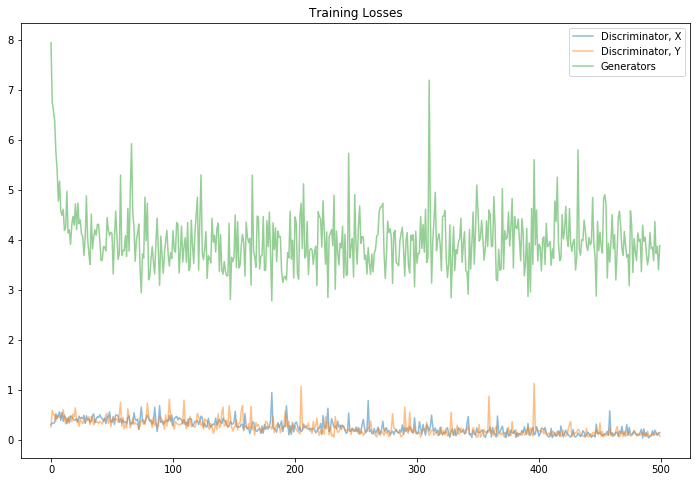

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='https://github.com/EliShayGH/deep-learning-v2-pytorch/blob/master/cycle-gan/notebook_images/sample-004000-summer2winter.png?raw=1' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [0]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


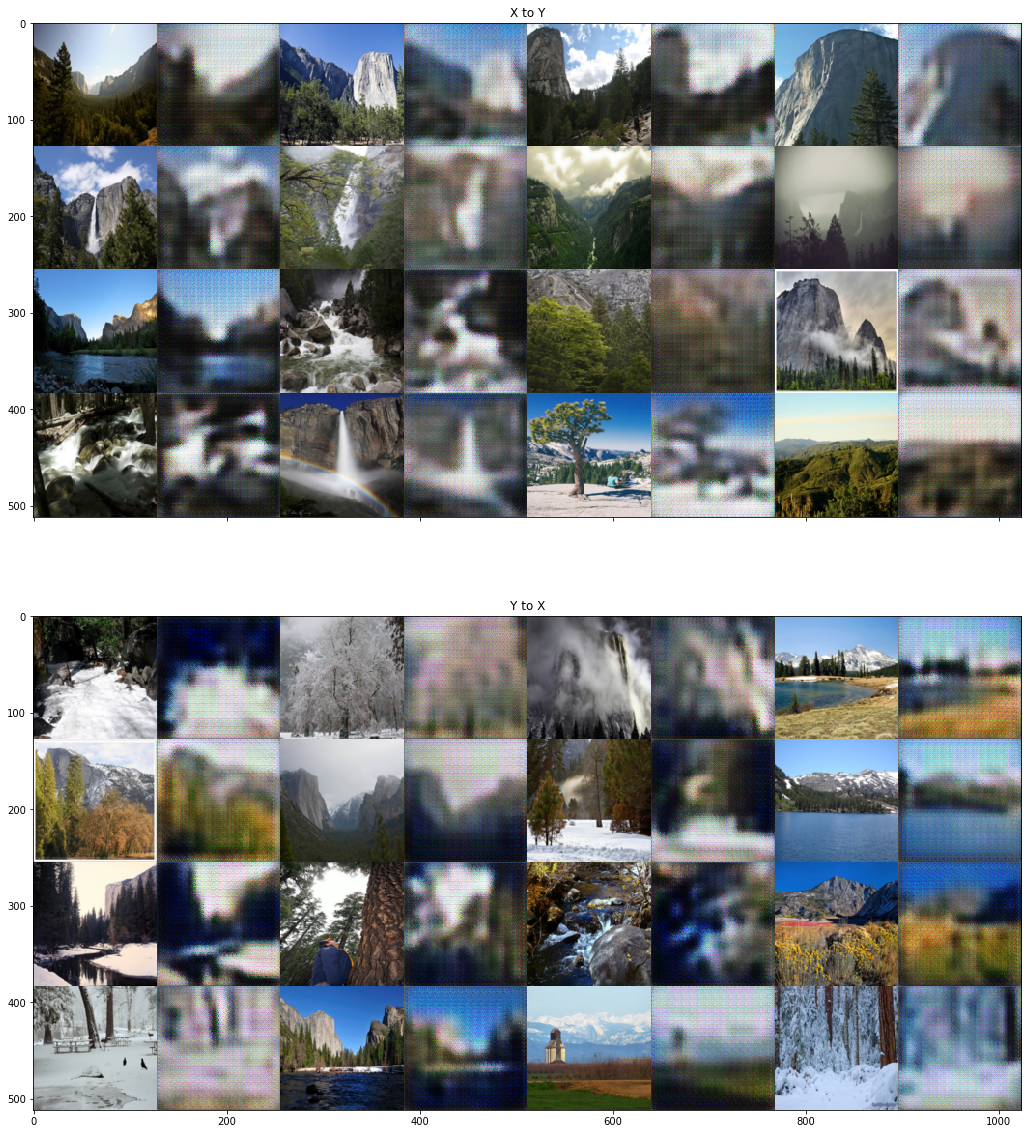

In [24]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

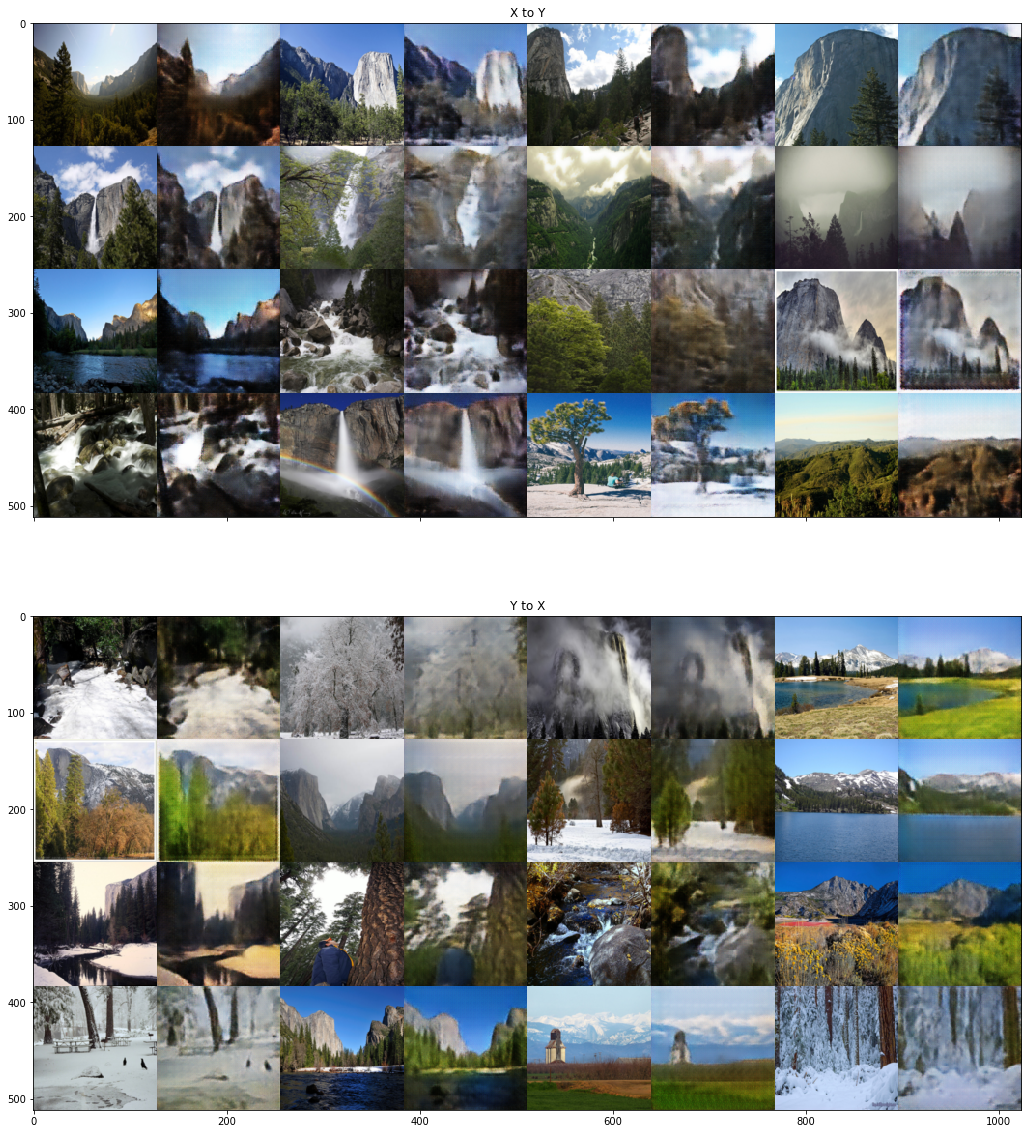

In [26]:
# view samples at iteration 1000
view_samples(5000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.